In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet152, preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.activations import relu, softmax, sigmoid, swish
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing import image

2022-11-28 09:15:52.631265: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";

# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')

tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-11-28 09:16:01.067730: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-28 09:16:01.070263: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-28 09:16:01.078537: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2022-11-28 09:16:01.078580: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: lnx00273.ad.liu.se
2022-11-28 09:16:01.078592: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: lnx00273.ad.liu.se
2022-11-28 09:16:01.078692: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.86.1
2022-11-28 09:16:01.078742: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.76.0

IndexError: list index out of range

In [3]:
datagenerator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    rotation_range=20,
    vertical_flip=True,
    width_shift_range=0.1,
    #featurewise_center=True,
    samplewise_center=True,
    samplewise_std_normalization=True,
    brightness_range=[0.90,1.25],
    fill_mode='nearest'
)

In [4]:
# load and iterate training dataset
train_data = datagenerator.flow_from_directory('../train/', 
    class_mode='binary',
    target_size=(224, 224), 
    batch_size=32, 
    shuffle=True)

# load and iterate validation dataset
val_data = datagenerator.flow_from_directory('../valid/', 
    class_mode='binary',
    target_size=(224, 224),
    batch_size=1, 
    shuffle=False)

# load and iterate test dataset
test_data = datagenerator.flow_from_directory('../test/', 
    class_mode='binary',
    target_size=(224, 224),
    batch_size=1, 
    shuffle=False)

Found 2600 images belonging to 2 classes.
Found 870 images belonging to 2 classes.
Found 864 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The dimensions of the image are 224 pixels width and 224 pixels height, one single color channel.
The maximum pixel value is 1.2077 and the minimum is -0.9983
The mean value of the pixels is 0.0000 and the standard deviation is 1.0000


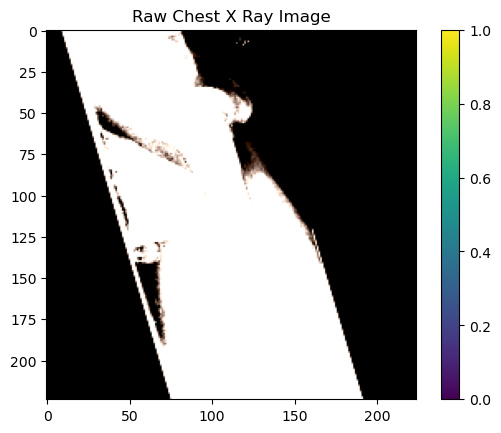

In [6]:
#sns.set_style('white')
generated_image, label = val_data.__getitem__(0)
plt.imshow(generated_image[0])

plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height, one single color channel.")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

In [7]:
generated_image.shape

(1, 224, 224, 3)

In [8]:
pre_trained_model_resnet152 = ResNet152(input_shape=(224,224,3),
                                include_top=False,
                                weights="imagenet")

2022-11-26 17:58:35.557340: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-26 17:58:35.557824: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-26 17:58:35.558192: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 17:58:35.558541: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce RTX 3060 Ti computeCapability: 8.6
coreClock: 1.755GHz coreCount: 38 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.

In [11]:
# Some weights in later layers are unfreezed
for layer in pre_trained_model_resnet152.layers:
    layer.trainable=False

tf.random.set_seed(15)

model = tf.keras.models.Sequential([
    pre_trained_model_resnet152,
    GlobalAveragePooling2D(),    
    Dense(512,activation="relu"),
    Dropout(0.4),
    Dense(256,activation="relu"),
    Dropout(0.4),
    Dense(128, activation='swish'),  
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss="binary_crossentropy",
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, 7, 7, 2048)        58370944  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

In [13]:
history = model.fit(
    train_data,
    epochs=5,
    validation_data=val_data  
)

2022-11-26 18:02:58.712185: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-26 18:02:58.713142: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3491795000 Hz


Epoch 1/5


2022-11-26 18:03:05.985586: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-11-26 18:03:16.304075: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-11-26 18:12:32.211511: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-11-26 18:12:32.298002: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


82/82 [==============================] - 1149s 7s/step - loss: 348.0216 - accuracy: 0.7736 - val_loss: 0.6631 - val_accuracy: 0.7989
Epoch 2/5
82/82 [==============================] - 516s 6s/step - loss: 0.6544 - accuracy: 0.8099 - val_loss: 0.6308 - val_accuracy: 0.7989
Epoch 3/5
82/82 [==============================] - 484s 6s/step - loss: 0.6237 - accuracy: 0.7890 - val_loss: 0.5890 - val_accuracy: 0.7989
Epoch 4/5
82/82 [==============================] - 485s 6s/step - loss: 0.5783 - accuracy: 0.7961 - val_loss: 0.5437 - val_accuracy: 0.7989
Epoch 5/5
82/82 [==============================] - 486s 6s/step - loss: 0.5355 - accuracy: 0.7984 - val_loss: 0.5143 - val_accuracy: 0.7989


In [14]:
model.evaluate(test_data)

864/864 [==============================] - 159s 184ms/step - loss: 0.5134 - accuracy: 0.7998


[0.5134024024009705, 0.7997685074806213]